In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from cellfate import model, io, celldensity
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op

## The Data

This package accepts data in the form of csv files outputed by the CellProfiler Software available from MIT's Broad Institute (cellprofiler.org). 

The example data used here is processed time-lapse images of differentiating stem cells with tagged transcription factors.

<img src="t1.png" width="300" height="300">

The example cells are embryonic stem cells modified using CRISPR so as to create two tagged transcription factors: Oct4-mCherry and Sox2-GFP. These show up respectively in the red and green channels of our time lapse image set. Above is a composite image of the starting time point. Green cells become neurectoderm (Sox2 only), and red cells become mesendoderm (Oct4 only). 

CellProfiler can then be used to segment images and classify cells by relative color. A segmented version of the above image is shown below.

<img src="t1-segmented.png" width="300" height="300">

In this sample, cells were classified using the upper quartile intensity of each identified nuclei. The yellow color indicated red-dominated cells, the aqua indicates green-dominated, and navy and burgandy indicate the undifferentiated "both" cell state. 

<img src="t1-classified.png" width="300" height="300">

CellProfiler was then used to export the nuclear locations and classifications to a csv file. Our package is configured to read these default-configured CellProfiler output CSV files (created using the ExportToSpreadsheet analysis module).

The images shown above are for the first of 175 time steps in our sample data set. 

## I. Data Import

### (A) Import the CSV file
Data for the location of different cell types is imported from CSV files, which have to be put in a directory in the cellfate package. The default directory is 'test'. The CSV file should contain the following column headers:<br/>
- $\textbf{For identity Labeling}$ <br/>
  * Column 0:'ImageNumber': denoting the time step image
  * Column 1: 'ObjectNumber': denoting the arbitrary identity of the cell
- $\textbf{Intensity classifications:}$<br/>
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_high_Intensity_UpperQuartileIntensity_CellB_high'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_high_Intensity_UpperQuartileIntensity_CellB_low'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_low_Intensity_UpperQuartileIntensity_CellB_high'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_low_Intensity_UpperQuartileIntensity_CellB_low'<br/>
  (where 'CellA' and 'CellB' are the name of the two cell types)
- $\textbf{Locations:}$<br/>
  * 'Location_Center_X': denoting the x coordinate of the cell location.
  * 'Location_Center_Y': denoting the y coordinate of the cell location.

The classification was done using the upper quartile intensity of each segmented cell. This is accessed in the function cell_density in the module celldensity.py. This function is capable of dividing the original image into a number of bins and counting the cell density in each bin.  

We can read in data directly using io.read, which would return an object with information of the measurement like the total duration, names of the cells, total number of bins and most importantly, a dataframe containing the calculated the cell density in every bin at different time.

In [12]:
# This is an example of reading the CSV using io.read.
# The image is divided into 2x2 bins in this example.

# Cautions:
# 1) the order of cell names has to follow that of CellA and CellA in the headers.
# 2) The original image is assumed to be a square image.
# 3) Since the default value of image size is 1024x1024, if your image is of different size,
#    you may have to add another parameter ImgWidth. 

our_data=io.read('full-data.csv', 'Sox2', 'Oct4', 2)

# To take a look at the cell density in different bin,
# we could just retrieve the attribute 'data'
our_data.data

Sox2                        Oct4                        Both          \
        0      1      2      3      0      1      2      3      0       1   
0    11.0   33.0  116.0  569.0  123.0  270.0  294.0  117.0  205.0   763.0   
1     4.0   34.0   96.0  660.0  176.0  360.0  365.0   66.0  200.0   789.0   
2    22.0   67.0  255.0  841.0  306.0  578.0  312.0  110.0  312.0  1065.0   
3    18.0   73.0  271.0  795.0  291.0  582.0  282.0  128.0  310.0  1048.0   
4    21.0   75.0  292.0  784.0  292.0  588.0  318.0   98.0  302.0  1029.0   
5    21.0   78.0  277.0  778.0  300.0  600.0  269.0  124.0  286.0  1004.0   
6    19.0   70.0  294.0  747.0  273.0  558.0  269.0  113.0  302.0  1057.0   
7    24.0   66.0  314.0  740.0  291.0  571.0  290.0  118.0  288.0  1029.0   
8    19.0   71.0  298.0  752.0  289.0  622.0  253.0  113.0  300.0   977.0   
9    23.0   68.0  316.0  749.0  296.0  609.0  270.0  107.0  279.0  1001.0   
10   19.0   73.0  320.0  749.0  291.0  602.0  257.0  102.0  283.0   994.0   
11   16.0   67.0  316.0  744.0  286.0  622.0  251.0  103.0  288.0   958.0   
12    7.0   36.0  113.0  679.0  185.0  367.0  390.0   65.0  203.0   783.0   
13   17.0   68.0  285.0  726.0  288.0  593.0  254.0  101.0  280.0   992.0   
14   15.0   54.0  292.0  697.0  306.0  607.0  223.0  106.0  247.0   986.0   
15   18.0   56.0  318.0  733.0  292.0  591.0  251.0  119.0  245.0   942.0   
16   15.0   65.0  315.0  677.0  294.0  574.0  258.0  123.0  255.0   976.0   
17   16.0   60.0  311.0  689.0  291.0  581.0  246.0  106.0  241.0   967.0   
18   16.0   54.0  335.0  702.0  294.0  580.0  227.0  115.0  247.0   976.0   
19   15.0   51.0  340.0  699.0  295.0  608.0  244.0  122.0  230.0   958.0   
20   11.0   58.0  342.0  704.0  301.0  624.0  268.0  121.0  220.0   944.0   
21   14.0   45.0  336.0  704.0  284.0  644.0  261.0  119.0  230.0   932.0   
22   12.0   61.0  348.0  676.0  294.0  649.0  254.0  120.0  221.0   893.0   
23   10.0   41.0  101.0  679.0  196.0  362.0  411.0   74.0  186.0   766.0   
24   15.0   57.0  327.0  696.0  272.0  649.0  245.0  125.0  245.0   898.0   
25   18.0   58.0  343.0  697.0  282.0  670.0  275.0  122.0  237.0   893.0   
26   17.0   58.0  346.0  691.0  273.0  697.0  262.0  119.0  240.0   898.0   
27   14.0   58.0  349.0  686.0  292.0  685.0  251.0  135.0  234.0   893.0   
28   13.0   56.0  314.0  701.0  286.0  698.0  261.0  120.0  223.0   871.0   
29   13.0   72.0  335.0  713.0  292.0  700.0  277.0  114.0  211.0   863.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
145  20.0   76.0  294.0  618.0  246.0  493.0  255.0  130.0  332.0  1127.0   
146  25.0   74.0  300.0  634.0  260.0  530.0  278.0  136.0  318.0  1110.0   
147  26.0   83.0  302.0  631.0  259.0  548.0  283.0  127.0  321.0  1112.0   
148  16.0   72.0  308.0  640.0  255.0  576.0  293.0  132.0  332.0  1077.0   
149  14.0   74.0  310.0  667.0  259.0  541.0  288.0  111.0  331.0  1135.0   
150  15.0   83.0  327.0  676.0  267.0  546.0  282.0  113.0  339.0  1092.0   
151  11.0   87.0  333.0  676.0  277.0  545.0  296.0  107.0  349.0  1135.0   
152  16.0   95.0  339.0  675.0  291.0  578.0  296.0  103.0  320.0  1110.0   
153   5.0   38.0  106.0  653.0  153.0  321.0  352.0   87.0  213.0   825.0   
154  15.0   99.0  337.0  736.0  311.0  549.0  263.0  110.0  312.0  1117.0   
155  12.0  119.0  309.0  819.0  289.0  607.0  364.0  133.0  284.0  1077.0   
156  17.0  104.0  306.0  807.0  297.0  600.0  352.0  104.0  303.0  1091.0   
157  16.0   95.0  303.0  803.0  299.0  579.0  372.0  123.0  299.0  1088.0   
158  17.0  103.0  306.0  808.0  310.0  606.0  371.0   97.0  280.0  1048.0   
159  13.0  103.0  308.0  835.0  304.0  575.0  411.0  121.0  290.0  1110.0   
160  19.0  109.0  310.0  841.0  299.0  619.0  408.0  109.0  291.0  1067.0   
161  26.0  126.0  297.0  834.0  328.0  570.0  413.0   93.0  291.0  1077.0   
162  18.0  134.0  267.0  851.0  320.0  593.0  399.0   96.0  302.0  1046.0   
163  21.0  125.0  260.0  849.0  308.0  596.0  413.0   93.0  301.0  1013.0   
1

In the above dataframe, the main columns are different cell types. The sub-columns are the index of the bin, which is in the same order as the usual way of labelling matrix element in python. The rows are different time points.

In [16]:
# Other attribute of the object output from io.read includes:

# 1) The names of the cell
cellnameA,cellnameB = our_data.cellname
print('The cells involved are',cellnameA,'and',cellnameB)

# 2) How many number of bin is divided into in one direction
print('The image is divided into',our_data.bin_num,'x',our_data.bin_num,'bins.')

# 3) How long is the duration of the measurement
print('The measurement was lasted for',our_data.tot_time,'seconds.')

The cells involved are Sox2 and Oct4
The image is divided into 2 x 2 bins.
The measurement was lasted for 175 seconds.


### (B) Take a look at the cell distribution

Very often, although it is not necessary, it is useful to get an idea of how the cell distribution in the data would look like so that we can do the analysis with more intuition.<br/>

This can be done by the function draw_cell_loc in the celldensity module. You could just choose what time of cell distribution you want to look at.

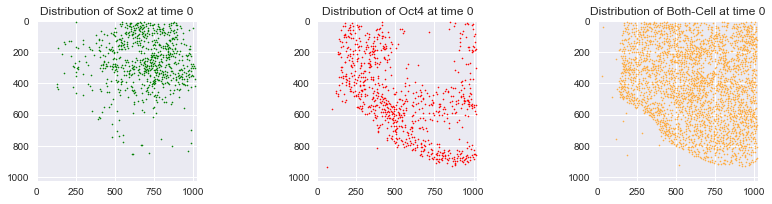

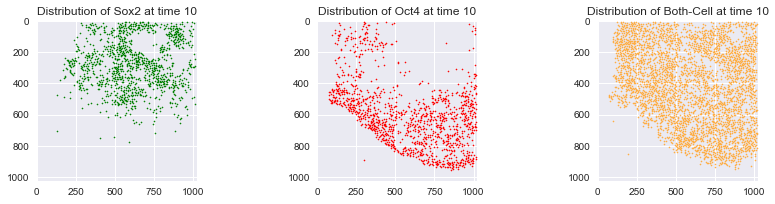

In [5]:
# Take a look at the cell distribution at time = 0
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', 0)

# Take a look at the cell distribution at time = 10
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', 10)

Since we are going to divide the image into bins and count the cell density in each of them, we could also use the draw_cell_loc function to look at the cell distribution a specfied bin. <br/>

(Note that every index, including time index, bin coordinates and bin index start from 0, as the python convention)

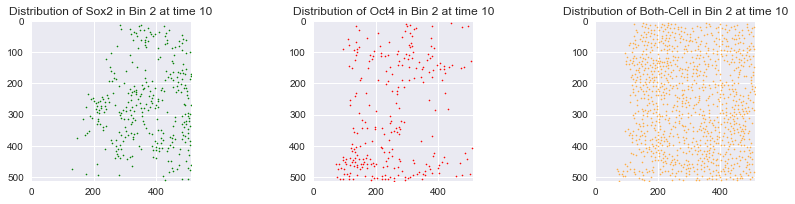

In [10]:
# If we divide the image into 2x2 bins (=> BinDiv =2)
# and we want to take a look at the cell distribution at time = 10 
# in bin (1,0) (=> bin_i=0, bin_j=1) so that whose bin index would be 1*BinDiv+0=2.
celldensity.draw_cell_loc('full-data.csv', 'Sox2', 'Oct4', 10, BinDiv=2, bin_i=1, bin_j=0)

## II. Inference

#### Model
Firstly, model should be specified in the function "diffeq" of model.py. Currently, the model is generated with the following system of differential equations:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + k_{b\rightarrow g } n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + k_{b\rightarrow r } n_{r}(t,x,y) $$

In [4]:
def diffeq(w, t, p):
    """
    Defines the differential equations for our model.

    Arguments:
        w :  vector of the state variables:
                  w = [red, grn, both]
        t :  time
        p :  vector of the parameters:
                  p = [k_div, k_bg, k_br]
    """
    grn, red, both = w
    k_div, k_bg, k_br = p

    # Create f = (red,grn,both) - order should be same as in w vector:
    f = [k_div*grn + k_bg*both,
         k_div*red + k_br*both,
         k_div*both - (k_bg+k_br)*both]

    return f

#### MCMC Run

With the created celldensity object, we can run MCMC by using the model module.

In [6]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.fmin(model.negative_log_posterior, x0, args=(data, 1000))

print(res)

Optimization terminated successfully.
         Current function value: 65838.263699
         Iterations: 109
         Function evaluations: 204
[  1.54669528e-10   6.96645013e-01   6.88803015e-01]


In [8]:
# We have 3 parameters. 
# We use 20 walkers and 500 steps, which turns out to be a sufficient number.
ndim = 3
nwalkers = 20
nsteps = 500
init_params = res

# Starting positions in Gaussian ball
starting_positions = [init_params + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, model.log_posterior, 
                                args=(data, 1000))

# Run the sampler.
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 58.2 s, sys: 306 ms, total: 58.5 s
Wall time: 59.2 s
Done


#### Visualizing MCMC run

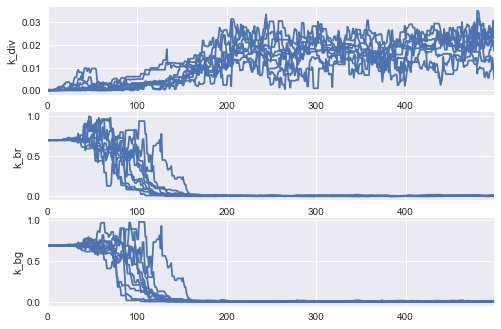

In [9]:
# Let's plot 10 walkers from the samler chain to observe convergence.
fig, (ax_k_div, ax_k_br, ax_k_bg) = plt.subplots(3)
ax_k_div.set(ylabel='k_div')
ax_k_br.set(ylabel='k_br')
ax_k_bg.set(ylabel='k_bg')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_k_br)
    sns.tsplot(sampler.chain[i,:,2], ax=ax_k_bg)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


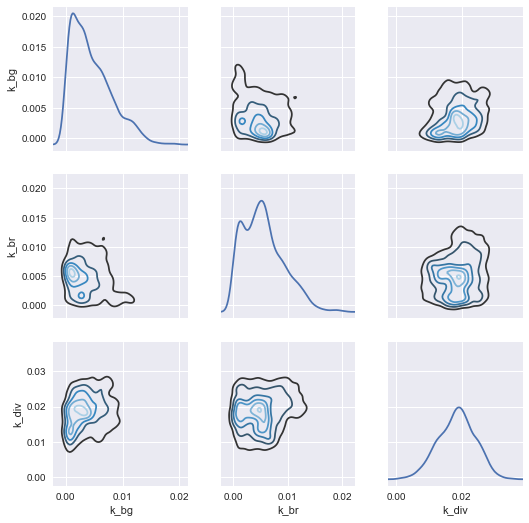

In [10]:
# Since V_b converges around 300, let's set burnin time as 300 steps.
samples = sampler.chain[:,300:,:]

# reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
traces = samples.reshape(-1, ndim).T

# Create a pandas DataFrame with labels.
parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_br': traces[1], 'k_bg': traces[2]})

# Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
g = sns.PairGrid(parameter_samples)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);